# Similarity Classification

In [1]:
import os
import glob

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import normalize

import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import functional as F

##### Load model

In [2]:
# model = torchvision.models.resnet18(pretrained=True).to('cuda:3')
model = torchvision.models.resnet34(pretrained=True).to('cuda:3')
# model = torchvision.models.resnet50(pretrained=True).to('cuda:3')
# model = torchvision.models.resnet101(pretrained=True).to('cuda:3')
# model = torchvision.models.resnet152(pretrained=True).to('cuda:3')

print(list(model.children())[0])
print(list(model.children())[-1])

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Linear(in_features=512, out_features=1000, bias=True)


In [3]:
def img_to_tensor(img):
    return F.to_tensor(img).unsqueeze(0).to('cuda:3', dtype=torch.float)

def save_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

def hook_activation(model, name):
    model.avgpool.register_forward_hook(save_activation(name))

def get_activation(model, name):
    return activation[name].squeeze().detach().cpu().numpy()
    
x = np.random.randint(0, 255, (640, 480, 3))
x = img_to_tensor(x)

activation = {}
hook_activation(model, 'avgpool')
model(x)
act = get_activation(model, 'avgpool')

print(np.shape(act.squeeze()))
act[:3]

(512,)


array([0.87804794, 0.82391214, 0.94440013], dtype=float32)

### Analyze latent space

In [4]:
path_exemplars = os.path.join(os.environ['DATASETS'], 'logos', 'exemplars')
save_name = os.path.join(path_exemplars, 'exemplars')
logos_path = sorted(glob.glob(path_exemplars + '/*.jpg'))

In [5]:
vectors = np.zeros((len(logos_path), 512))
for idx, logo in enumerate(logos_path):
    img = Image.open(logo).convert('RGB').resize((128, 128))
    img = F.to_tensor(img).unsqueeze(0).to('cuda:3', dtype=torch.float)
    model(img)
    act = activation['avgpool'].squeeze().detach().cpu().numpy()
    vectors[idx, :] = act

In [6]:
def clean_name(name):
    '''
    >> ' '.join(sorted(set(''.join(list(set(brands))))))
    >> "& ' + - 1 2 3 4 ? a b c d e f g h i j kl m n
        o p q r s t u v w x y z \udcbc \udcc3 \udcfc"
    '''
    filename = name.split('/')[-1]
    brand = filename.split('_')[0]
    return brand.encode('ascii', 'replace').decode()

In [7]:
# Save data:
vectors_list = [v for v in vectors]
brands = [clean_name(p) for p in logos_path]
logos_df = pd.DataFrame({'brand': brands, 'img_vec': vectors_list})
logos_df.to_pickle(save_name + '.zip')

#### Minkowski (p=1)

In [8]:
dists_mat_1 = np.zeros((len(logos_path), len(logos_path)))
for idx, vec in enumerate(vectors):
    neigh = KNeighborsClassifier(n_neighbors=1, metric='minkowski', p=1)
    neigh.fit([vec], [1])
    dists, classes = neigh.kneighbors(vectors)
    dists_mat_1[:, idx] = dists.flatten()
dists_mat_1 = pd.DataFrame(normalize(dists_mat_1, axis=0, norm='l2'))

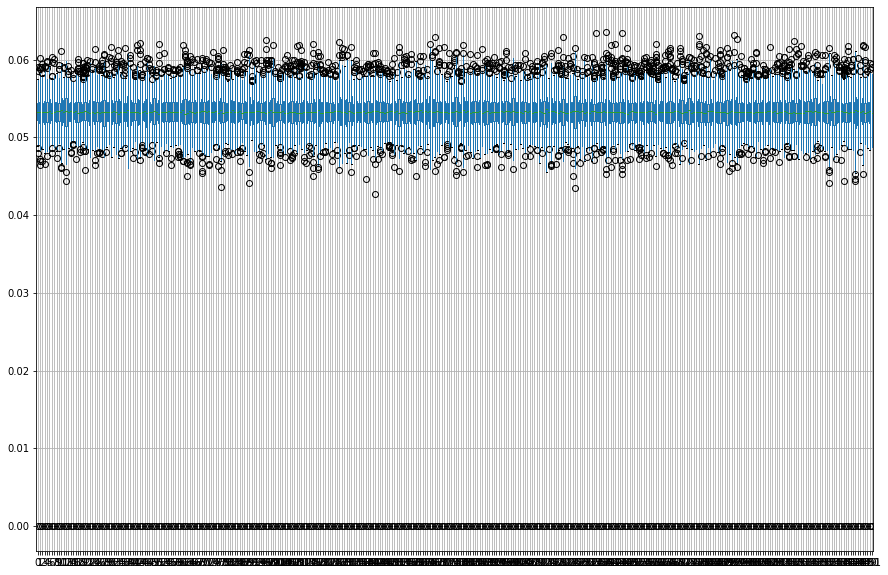

In [9]:
plt.figure(figsize=(15, 10))
dists_mat_1.boxplot()

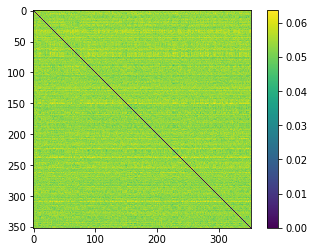

In [10]:
plt.imshow(dists_mat_1)
plt.colorbar()

In [11]:
dists_mat_1.describe().T.describe()

,count,mean,std,min,25%,50%,75%,max
count,352.0,352.000000,352.000000,352.0,352.000000,352.000000,352.000000,352.000000
mean,352.0,0.053186,0.003495,0.0,0.051955,0.053293,0.054642,0.059872
std,0.0,0.000011,0.000171,0.0,0.000216,0.000096,0.000216,0.001176
min,352.0,0.053145,0.003251,0.0,0.051272,0.053011,0.054278,0.057450
25%,352.0,0.053180,0.003365,0.0,0.051819,0.053234,0.054492,0.059028
50%,352.0,0.053189,0.003444,0.0,0.052003,0.053287,0.054586,0.059657
75%,352.0,0.053194,0.003582,0.0,0.052114,0.053350,0.054744,0.060587
max,352.0,0.053201,0.004071,0.0,0.052379,0.053636,0.055363,0.063586


#### Minkowski (p=2)

In [12]:
dists_mat_2 = np.zeros((len(logos_path), len(logos_path)))
for idx, vec in enumerate(vectors):
    neigh = KNeighborsClassifier(n_neighbors=1, metric='minkowski', p=2)
    neigh.fit([vec], [1])
    dists, classes = neigh.kneighbors(vectors)
    dists_mat_2[:, idx] = dists.flatten()
dists_mat_2 = pd.DataFrame(normalize(dists_mat_2, axis=0, norm='l2'))

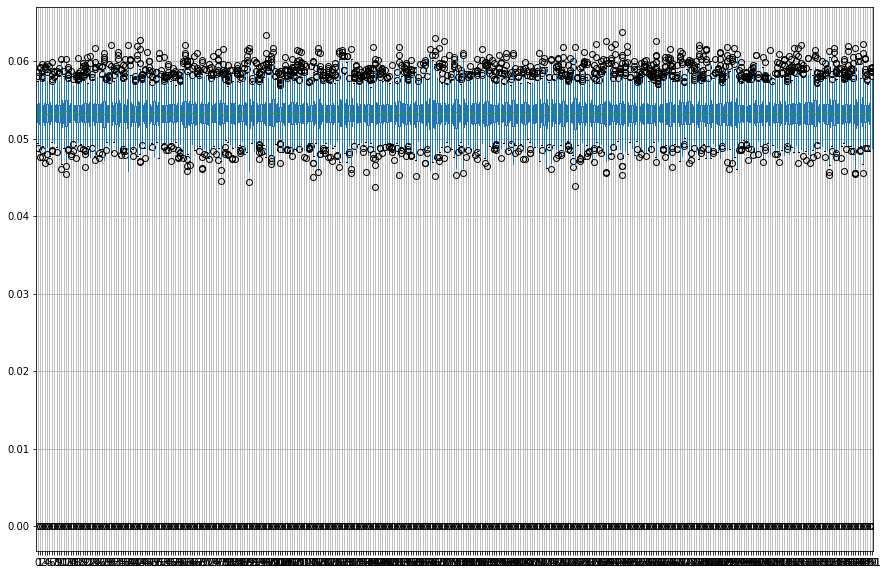

In [13]:
plt.figure(figsize=(15, 10))
dists_mat_2.boxplot()

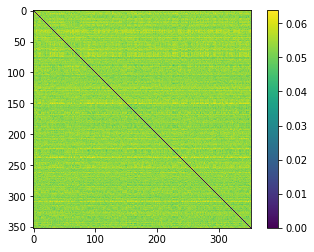

In [14]:
plt.imshow(dists_mat_2)
plt.colorbar()

In [15]:
dists_mat_2.describe().T.describe()

,count,mean,std,min,25%,50%,75%,max
count,352.0,352.000000,352.000000,352.0,352.000000,352.000000,352.000000,352.000000
mean,352.0,0.053189,0.003447,0.0,0.052011,0.053283,0.054582,0.059755
std,0.0,0.000012,0.000177,0.0,0.000237,0.000096,0.000235,0.001239
min,352.0,0.053148,0.003206,0.0,0.051242,0.053040,0.054153,0.057478
25%,352.0,0.053182,0.003312,0.0,0.051862,0.053225,0.054405,0.058802
50%,352.0,0.053192,0.003396,0.0,0.052076,0.053285,0.054522,0.059556
75%,352.0,0.053197,0.003548,0.0,0.052192,0.053335,0.054712,0.060589
max,352.0,0.053204,0.004026,0.0,0.052429,0.053603,0.055336,0.063803


#### Cosine

In [16]:
dists_mat_3 = np.zeros((len(logos_path), len(logos_path)))
for idx, vec in enumerate(vectors):
    neigh = KNeighborsClassifier(n_neighbors=1, metric='cosine')
    neigh.fit([vec], [1])
    dists, classes = neigh.kneighbors(vectors)
    dists_mat_3[:, idx] = dists.flatten()
dists_mat_3 = pd.DataFrame(normalize(dists_mat_3, axis=0, norm='l2'))

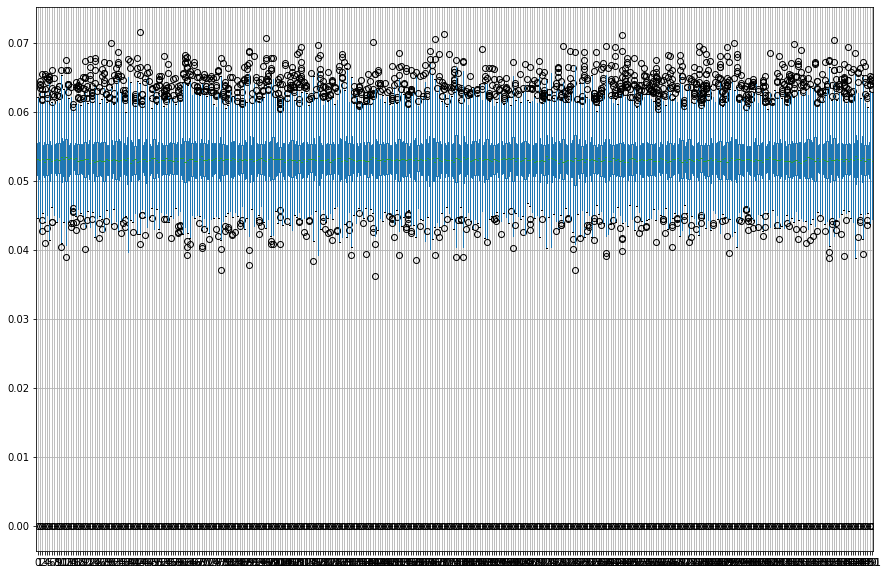

In [17]:
plt.figure(figsize=(15, 10))
dists_mat_3.boxplot()

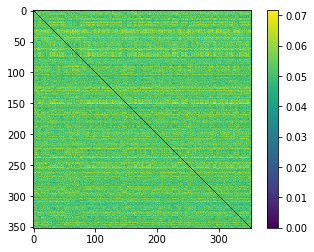

In [18]:
plt.imshow(dists_mat_3)
plt.colorbar()

In [19]:
dists_mat_3.describe().T.describe()

,count,mean,std,min,25%,50%,75%,max
count,352.0,352.000000,352.000000,352.0,352.000000,352.000000,352.000000,352.000000
mean,352.0,0.053094,0.004677,0.0,0.050676,0.053092,0.055599,0.065480
std,0.0,0.000037,0.000403,0.0,0.000420,0.000184,0.000365,0.002044
min,352.0,0.052961,0.004051,0.0,0.049314,0.052582,0.054897,0.061108
25%,352.0,0.053074,0.004363,0.0,0.050408,0.052972,0.055336,0.063903
50%,352.0,0.053105,0.004561,0.0,0.050766,0.053095,0.055504,0.065159
75%,352.0,0.053122,0.004912,0.0,0.050995,0.053209,0.055781,0.066756
max,352.0,0.053146,0.006014,0.0,0.051622,0.053638,0.056730,0.071608
